In [ ]:
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random

# 3.3.1
# The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100

.vector_cache/glove.6B.zip: 862MB [02:38, 5.43MB/s]                           
100%|█████████▉| 399999/400000 [00:28<00:00, 14086.74it/s]


In [ ]:
def splitData():
  df = pd.read_table('/content/data.tsv')

  train, test = train_test_split(df, test_size=0.2, random_state=40, stratify=df.label)
  training, validation = train_test_split(train, test_size=0.2, random_state=40, stratify=train.label)

  print('length of text of train set:',len(training.text))
  print('length of label of train set:',len(training.label))
  print('length of text of test set:',len(test.text))
  print('length of label of test set:',len(test.label))
  print('length of text of validation set:',len(validation.text))
  print('length of label of validation set:',len(validation.label))
  print('===========')
  print('length of label 0 of train set:',len(training[training['label']==0]))
  print('length of label 1 of train set:',len(training[training['label']==1]))
  print('length of label 0 of validation set:',len(validation[validation['label']==0]))
  print('length of label 1 of validation set:',len(validation[validation['label']==1]))
  print('length of label 0 of test set:',len(test[test['label']==0]))
  print('length of label 1 of test set:',len(test[test['label']==1]))
  print('===========')
  df3=pd.merge(training,test, how='inner')
  print('Do train set and test set have the same sample? ', not df3.empty)
  df4=pd.merge(training,validation, how='inner')
  print('Do train set and validation set have the same sample? ', not df4.empty)
  df5=pd.merge(test,validation, how='inner')
  print('Do test set and validation set have the same sample? ', not df5.empty)

  overFit = df.sample(n=50)
  overFit.to_csv('overfit.tsv', sep="\t")
  training.to_csv('train.tsv', sep="\t")
  test.to_csv('test.tsv', sep="\t")
  validation.to_csv('validation.tsv', sep="\t")

In [ ]:
# please upload data.tsv into colab
splitData()

length of text of train set: 6400
length of label of train set: 6400
length of text of test set: 2000
length of label of test set: 2000
length of text of validation set: 1600
length of label of validation set: 1600
length of label 0 of train set: 3200
length of label 1 of train set: 3200
length of label 0 of validation set: 800
length of label 1 of validation set: 800
length of label 0 of test set: 1000
length of label 1 of test set: 1000
Do train set and test set have the same sample?  False
Do train set and validation set have the same sample?  False
Do test set and validation set have the same sample?  False


In [ ]:
class TextDataset(torch.utils.data.Dataset):
  # TextDataset is Described in Section 3.3 of Assignment 2
    def __init__(self, vocab, split="train"):
        data_path = "data"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X
        self.Y = torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
# my_collate_function prepares batches
# it also pads each batch with zeroes.
def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device),
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [ ]:
class CNNModel(torch.nn.Module):
  def __init__(self, vocab,k1,k2,n1,n2):
    super().__init__()
    self.k1 = (k1, 100)
    self.k2 = (k2, 100)
    self.n1 = n1
    self.n2 = n2
    self.probabilityFunction = torch.nn.Sigmoid()

    self.embedding = torch.nn.Embedding.from_pretrained(vocab.vectors)

    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=self.n1, kernel_size=self.k1, bias=False)
    self.bn1 = torch.nn.BatchNorm2d(self.n1)
    self.maxpool1 = torch.nn.AdaptiveMaxPool2d(output_size=(1, 1))

    self.conv2 = torch.nn.Conv2d(in_channels=1, out_channels=self.n2, kernel_size=self.k2, bias=False)
    self.bn2 = torch.nn.BatchNorm2d(self.n2)
    self.maxpool2 = torch.nn.AdaptiveMaxPool2d(output_size=(1, 1))

    self.out = torch.nn.Linear(self.n1+self.n2, 1)

  def forward(self, x):
    e = self.embedding(x)
    input = torch.transpose(e, 0, 1).unsqueeze(1)
    x1 = self.conv1(input)
    x1 = F.relu(x1)
    x1 = self.bn1(x1)
    x1 = self.maxpool1(x1)

    x2 = self.conv2(input)
    x2 = F.relu(x2)
    x2 = self.bn2(x2)
    x2 = self.maxpool2(x2)

    concatenate = torch.cat((x1, x2), dim=1)
    output = self.out(concatenate.squeeze())
    logits = self.probabilityFunction(output)

    return logits.reshape([-1])

part 5.1

In [ ]:
def overfitTest(epochs,batchSize,learningRate,k1,k2,n1,n2):
    #   fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)

    overfit_dataset = TextDataset(glove, "overfit")

    overfit_dataloader = torch.utils.data.DataLoader(
        dataset=overfit_dataset,
        batch_size=batchSize,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    model = CNNModel(glove,k1=k1,k2=k2,n1=n1,n2=n2)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learningRate)
    lossFunction = torch.nn.BCEWithLogitsLoss()
    probabilityFunction = torch.nn.Sigmoid()

    totalLoss = []
    totalAccuray = []

    for i in range(epochs):
      currentEpochLoss = 0
      numbers = 0
      currentAccuray = 0
      for X_overfit, y_overfit in overfit_dataloader:
        optimizer.zero_grad()
        logits = model(x=X_overfit)
        currentLoss = lossFunction(logits, y_overfit.float())
        currentEpochLoss = currentEpochLoss + currentLoss
        currentLoss.backward()
        optimizer.step()

        probability = probabilityFunction(logits)
        probability = torch.maximum(probability, torch.tensor([1e-5]))
        probability = torch.minimum(probability, torch.tensor([0.99999]))
        Y_pred = torch.round(probability)

        n = 0
        for eachy_test in y_overfit:
          if eachy_test.item() == Y_pred[n]:
            currentAccuray  = currentAccuray + 1
          n = n + 1
        numbers = numbers + len(Y_pred)

      totalEpochAccuray = currentAccuray/numbers
      totalAccuray.append(totalEpochAccuray)

      averageCurrentEpochLoss = currentEpochLoss/len(overfit_dataloader)
      totalLoss.append(averageCurrentEpochLoss.item())

    return totalLoss, totalAccuray

Using device: cpu
1.0


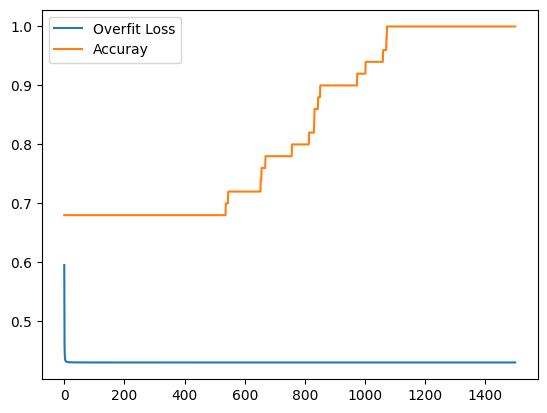

In [ ]:
# please create a folder called 'data' in colab and put 'overfit.tsv' 'train.tsv' 'test.tsv' 'validation.tsv' into 'data' folder
totalLossO, totalAccurayO = overfitTest(1500,4,0.001,2,4,50,50)
print(totalAccurayO[-1])
plt.plot(totalLossO, label='Overfit Loss')
plt.plot(totalAccurayO, label='Accuray')
plt.legend()

part 5.2.1

In [ ]:
def main(epochs,batchSize,learningRate,k1,k2,n1,n2):
    #   fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)

    ### 3.3 Processing of the data ###


    # 3.3.2

    train_dataset = TextDataset(glove, "train")
    val_dataset = TextDataset(glove, "validation")
    test_dataset = TextDataset(glove, "test")

    # 3.3.3
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batchSize,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))
    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batchSize,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batchSize,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    # Instantiate your model(s) and train them and so on
    # We suggest parameterizing the model - k1, n1, k2, n2, and other hyperparameters
    # so that it is easier to experiment with

    #4.3
    model = CNNModel(glove,k1=k1,k2=k2,n1=n1,n2=n2)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learningRate)
    lossFunction = torch.nn.BCEWithLogitsLoss()
    probabilityFunction = torch.nn.Sigmoid()

    totalLoss = []
    totalTestLoss = []
    totalValidationLoss = []
    totalAccuray = []

    for i in range(epochs):
      currentEpochLoss = 0
      currentEpochLossV = 0
      currentEpochLossT = 0
      currentEpochValidationLoss = 0
      for X_train, y_train in train_dataloader:
        optimizer.zero_grad()
        logits = model(x=X_train)
        currentLoss = lossFunction(logits, y_train.float())
        currentEpochLoss = currentEpochLoss + currentLoss
        currentLoss.backward()
        optimizer.step()

      averageCurrentEpochLoss = currentEpochLoss/len(train_dataloader)
      totalLoss.append(averageCurrentEpochLoss.item())

      for X_validation, y_validation in validation_dataloader:
        model.eval()
        with torch.no_grad():
          logitsV = model(x=X_validation)
        currentLossV = lossFunction(logitsV, y_validation.float())
        currentEpochLossV = currentEpochLossV + currentLossV

      averageCurrentEpochLossV = currentEpochLossV/len(validation_dataloader)
      totalValidationLoss.append(averageCurrentEpochLossV.item())

    #4.5
      currentAccuray = 0
      numbers = 0
      for X_test, y_test in test_dataloader:
        model.eval()
        with torch.no_grad():
          logitsT = model(x=X_test)
        currentLossT = lossFunction(logitsT, y_test.float())
        currentEpochLossT = currentEpochLossT + currentLossT

        probability = probabilityFunction(logitsT)
        probability = torch.maximum(probability, torch.tensor([1e-5]))
        probability = torch.minimum(probability, torch.tensor([0.99999]))
        Y_pred = torch.round(probability)

        n = 0
        for eachy_test in y_test:
          if eachy_test.item() == Y_pred[n]:
            currentAccuray  = currentAccuray + 1
          n = n + 1
        numbers = numbers + len(Y_pred)

      totalEpochAccuray = currentAccuray/numbers
      totalAccuray.append(totalEpochAccuray)

      averageCurrentEpochLossT = currentEpochLossT/len(validation_dataloader)
      totalTestLoss.append(averageCurrentEpochLossT.item())

    #4.7
    torch.save(model.state_dict(), '/content/CNNModel')


    return model, totalLoss, totalValidationLoss, totalTestLoss, totalAccuray

In [ ]:
#50,4,0.001,2,4,20,20 0.9085

Using device: cpu


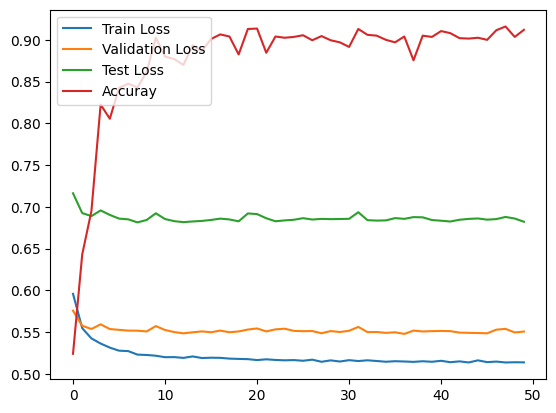

In [ ]:
# please create a folder called 'data' in colab and put 'overfit.tsv' 'train.tsv' 'test.tsv' 'validation.tsv' into 'data' folder
embedding, totalLoss, totalValidationLoss, totalTestLoss, totalAccuray = main(50,4,0.001,2,4,20,20)
plt.plot(totalLoss, label='Train Loss')
plt.plot(totalValidationLoss, label='Validation Loss')
plt.plot(totalTestLoss, label='Test Loss')
plt.plot(totalAccuray, label='Accuray')
plt.legend()

In [ ]:
print(totalAccuray[-1])

0.9085


In [ ]:
print(max(totalAccuray))

0.914


5.2.2

In [ ]:
class CNNModelNoFreeze(torch.nn.Module):
  def __init__(self, vocab,k1,k2,n1,n2):
    super().__init__()
    self.k1 = (k1, 100)
    self.k2 = (k2, 100)
    self.n1 = n1
    self.n2 = n2
    self.probabilityFunction = torch.nn.Sigmoid()

    self.embedding = torch.nn.Embedding.from_pretrained(vocab.vectors,freeze=False)

    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=self.n1, kernel_size=self.k1, bias=False)
    self.bn1 = torch.nn.BatchNorm2d(self.n1)
    self.maxpool1 = torch.nn.AdaptiveMaxPool2d(output_size=(1, 1))

    self.conv2 = torch.nn.Conv2d(in_channels=1, out_channels=self.n2, kernel_size=self.k2, bias=False)
    self.bn2 = torch.nn.BatchNorm2d(self.n2)
    self.maxpool2 = torch.nn.AdaptiveMaxPool2d(output_size=(1, 1))

    self.out = torch.nn.Linear(self.n1+self.n2, 1)

  def forward(self, x):
    e = self.embedding(x)
    input = torch.transpose(e, 0, 1).unsqueeze(1)
    x1 = self.conv1(input)
    x1 = F.relu(x1)
    x1 = self.bn1(x1)
    x1 = self.maxpool1(x1)

    x2 = self.conv2(input)
    x2 = F.relu(x2)
    x2 = self.bn2(x2)
    x2 = self.maxpool2(x2)

    concatenate = torch.cat((x1, x2), dim=1)
    output = self.out(concatenate.squeeze())
    logits = self.probabilityFunction(output)

    return logits.reshape([-1])

In [ ]:
def mainNoFreeze(epochs,batchSize,learningRate,k1,k2,n1,n2):
    #   fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)

    ### 3.3 Processing of the data ###


    # 3.3.2

    train_dataset = TextDataset(glove, "train")
    val_dataset = TextDataset(glove, "validation")
    test_dataset = TextDataset(glove, "test")

    # 3.3.3
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batchSize,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))
    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batchSize,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batchSize,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    # Instantiate your model(s) and train them and so on
    # We suggest parameterizing the model - k1, n1, k2, n2, and other hyperparameters
    # so that it is easier to experiment with

    #4.3
    model = CNNModelNoFreeze(glove,k1=k1,k2=k2,n1=n1,n2=n2)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learningRate)
    lossFunction = torch.nn.BCEWithLogitsLoss()
    probabilityFunction = torch.nn.Sigmoid()

    totalLoss = []
    totalTestLoss = []
    totalValidationLoss = []
    totalAccuray = []

    for i in range(epochs):
      print(i)
      currentEpochLoss = 0
      currentEpochLossV = 0
      currentEpochLossT = 0
      currentEpochValidationLoss = 0
      for X_train, y_train in train_dataloader:
        optimizer.zero_grad()
        logits = model(x=X_train)
        currentLoss = lossFunction(logits, y_train.float())
        currentEpochLoss = currentEpochLoss + currentLoss
        currentLoss.backward()
        optimizer.step()

      averageCurrentEpochLoss = currentEpochLoss/len(train_dataloader)
      totalLoss.append(averageCurrentEpochLoss.item())

      for X_validation, y_validation in validation_dataloader:
        model.eval()
        with torch.no_grad():
          logitsV = model(x=X_validation)
        currentLossV = lossFunction(logitsV, y_validation.float())
        currentEpochLossV = currentEpochLossV + currentLossV

      averageCurrentEpochLossV = currentEpochLossV/len(validation_dataloader)
      totalValidationLoss.append(averageCurrentEpochLossV.item())

    #4.5
      currentAccuray = 0
      numbers = 0
      for X_test, y_test in test_dataloader:
        model.eval()
        with torch.no_grad():
          logitsT = model(x=X_test)
        currentLossT = lossFunction(logitsT, y_test.float())
        currentEpochLossT = currentEpochLossT + currentLossT

        probability = probabilityFunction(logitsT)
        probability = torch.maximum(probability, torch.tensor([1e-5]))
        probability = torch.minimum(probability, torch.tensor([0.99999]))
        Y_pred = torch.round(probability)

        n = 0
        for eachy_test in y_test:
          if eachy_test.item() == Y_pred[n]:
            currentAccuray  = currentAccuray + 1
          n = n + 1
        numbers = numbers + len(Y_pred)

      totalEpochAccuray = currentAccuray/numbers
      totalAccuray.append(totalEpochAccuray)

      averageCurrentEpochLossT = currentEpochLossT/len(validation_dataloader)
      totalTestLoss.append(averageCurrentEpochLossT.item())

    #4.7
    torch.save(model.state_dict(), '/content/CNNNoFreezeModel')


    return model, totalLoss, totalValidationLoss, totalTestLoss, totalAccuray

Using device: cpu
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


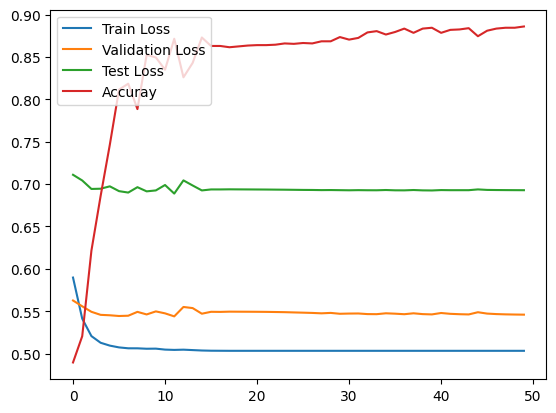

In [ ]:
# please create a folder called 'data' in colab and put 'overfit.tsv' 'train.tsv' 'test.tsv' 'validation.tsv' into 'data' folder
embeddingNoFreeze, totalLossNoFreeze, totalValidationLossNoFreeze, totalTestLossNoFreeze, totalAccurayNoFreeze = mainNoFreeze(50,4,0.001,2,4,20,20) #n1,2-20 0.903
plt.plot(totalLossNoFreeze, label='Train Loss')
plt.plot(totalValidationLossNoFreeze, label='Validation Loss')
plt.plot(totalTestLossNoFreeze, label='Test Loss')
plt.plot(totalAccurayNoFreeze, label='Accuray')
plt.legend()

In [ ]:
print(totalAccuray[-1])

0.886


5.3

In [ ]:
def print_closest_cosine_words(vec, n=5):
    dists = torch.cosine_similarity(glove.vectors, vec.unsqueeze(0))# compute distances to all words
    print(dists)
    lst = sorted(enumerate(dists.numpy()), key=lambda x: x[1]) # sort by distance
    for idx, difference in lst[:-n-1:-1]:                         # take the top n
        print(glove.itos[idx], "\t%5.2f" % difference)

In [ ]:
for g in range(0,5):
  index = random.randint(0,len(embedding.conv1.weight))
  print_closest_cosine_words(embedding.conv1.weight[g][0][0].detach(),5)

tensor([ 0.1351,  0.0347,  0.1043,  ..., -0.0811, -0.0835,  0.0595])
whereupon 	 0.51
divulging 	 0.48
blindfolds 	 0.48
ambushing 	 0.47
depositing 	 0.45
tensor([-0.1006, -0.1549, -0.1828,  ...,  0.1526,  0.0548,  0.0170])
buitoni 	 0.49
ozanam 	 0.46
vongola 	 0.45
palmes 	 0.44
vemork 	 0.44
tensor([-0.0408,  0.0070, -0.0063,  ...,  0.0243,  0.2301,  0.0461])
zords 	 0.43
3,399 	 0.42
holdouts 	 0.41
outshot 	 0.40
9-6 	 0.40
tensor([-0.0901, -0.0310, -0.1188,  ...,  0.0818,  0.0119, -0.0338])
heartened 	 0.54
cautiously 	 0.53
surefooted 	 0.53
terrifically 	 0.51
encouragingly 	 0.51
tensor([-0.2193, -0.0411, -0.0271,  ...,  0.1270,  0.1372,  0.0581])
chy 	 0.44
gehr 	 0.43
boda 	 0.42
augured 	 0.42
wrang 	 0.41


In [ ]:
for g in range(0,5):
  index = random.randint(0,len(embedding.conv2.weight))
  print_closest_cosine_words(embedding.conv2.weight[g][0][0].detach(),5)

tensor([-0.2936, -0.4698, -0.3348,  ...,  0.2274,  0.4005,  0.2613])
jaitapur 	 0.64
220.9 	 0.62
arpa-e 	 0.61
201.9 	 0.61
386.5 	 0.60
tensor([-0.1563, -0.0108,  0.0390,  ...,  0.2509,  0.1719,  0.0810])
segredo 	 0.47
lihd 	 0.46
oo.oo 	 0.46
wouldn 	 0.45
guhng 	 0.45
tensor([ 0.0064, -0.0247, -0.0386,  ...,  0.1091,  0.0145,  0.0598])
demonstrates 	 0.47
theorem 	 0.43
supercharges 	 0.42
implies 	 0.42
gymnopilus 	 0.42
tensor([ 0.0055, -0.0567, -0.0198,  ...,  0.1451,  0.0249,  0.0472])
1030s 	 0.43
1180s 	 0.41
1170s 	 0.40
1140s 	 0.40
adelsverein 	 0.39
tensor([-0.3152, -0.1163, -0.1058,  ...,  0.3193,  0.1676,  0.1824])
naah 	 0.50
leeze 	 0.49
dunno 	 0.49
pshaw 	 0.48
healthwise 	 0.48


In [ ]:
for g in range(0,5):
  index = random.randint(0,len(embeddingNoFreeze.conv1.weight))
  print_closest_cosine_words(embeddingNoFreeze.conv1.weight[g][0][0].detach(),5)

In [ ]:
for g in range(0,5):
  index = random.randint(0,len(embeddingNoFreeze.conv2.weight))
  print_closest_cosine_words(embeddingNoFreeze.conv2.weight[g][0][0].detach(),5)